In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import string
import re
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_is_fitted
from datetime import datetime
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from itertools import chain
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction
from sklearn import model_selection as ms
from sklearn import naive_bayes
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
import bs4 as bs4
import requests
import pandas as pd
import os
import spacy as sp
import re

from spacy.lang.en.examples import sentences
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from urllib.parse import urlparse
from collections import Counter
from bs4 import BeautifulSoup

class ScrapTool:
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        # headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
        content = requests.get(website_url, timeout=60).content

        # lxml is apparently faster than other settings.
        soup = BeautifulSoup(content, "lxml")
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup) + self.get_html_meta_tags(soup) + self.get_html_heading_tags(
                soup) +
                            self.get_text_content(soup)
        }

        # Convert to Series object and return
        return pd.Series(result)

    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])

    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)

    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name == "meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords', 'description']]
        return ' '.join(content)

    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1", "h2", "h3", "h4", "h5", "h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)

    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]', "h1", "h2", "h3", "h4", "h5", "h6",
                          "noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore \
                    and isinstance(tag, bs4.element.Comment) == False \
                    and not stripped_tag.isnumeric() \
                    and len(stripped_tag) > 0:
                result.append(stripped_tag)
        return ' '.join(result)

sp.prefer_gpu()

# anconda prompt ko run as adminstrator and copy paste this:python -m spacy download en
nlp = sp.load("en_core_web_sm")

def clean_text(doc):
    '''
    Clean the document. Remove pronouns, stopwords, lemmatize the words and lowercase them
    '''
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (
                token.text.isalnum() == False) or token.text in exclusion_list:
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens)


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


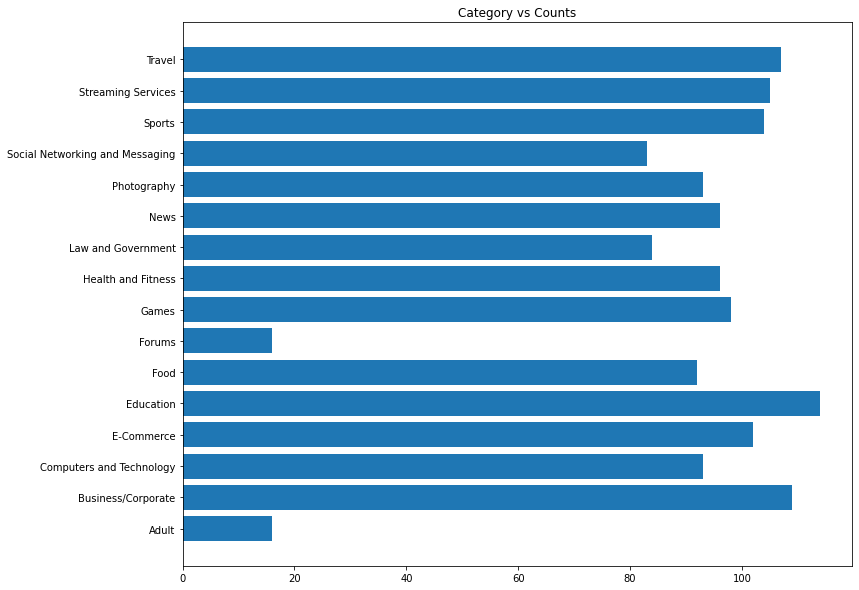

In [3]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

website_df = pd.read_csv('/content/website_classification.csv')
website_url_df = website_df[['website_url', 'Category']]
website_df.drop(['Unnamed: 0', 'website_url'], axis=1, inplace=True)

plt.figure(figsize=(12, 10))
plt.title('Category vs Counts')
website_category_df = pd.DataFrame(website_df.groupby('Category').size(), columns=['Count'])
plt.barh(width=website_category_df['Count'], y=website_category_df.index)
plt.show()

website_df['tokenized_words'] = website_df['cleaned_website_text'].apply(lambda x: word_tokenize(x))
website_df['tokenized_words'] = website_df['tokenized_words'].apply(lambda x: [re.sub(f'[{string.punctuation}]+', '', i) for i in x if i not in list(string.punctuation)])

website_df['tokenized_words'] = website_df['tokenized_words'].apply(lambda x: [i for i in x if i not in stopwords.words('english')])
wordnetlemmatizer = WordNetLemmatizer()
website_df['tokenized_words'] = website_df['tokenized_words'].apply(lambda x: [wordnetlemmatizer.lemmatize(i) for i in x])
website_df['tokenized_words'] = website_df['tokenized_words'].apply(lambda x: ' '.join(x))
website_df.drop(['cleaned_website_text'], axis=1, inplace=True)
website_df = website_df[['tokenized_words', 'Category']]
website_df.columns = ['Website Cleaned Text', 'Category']

website_df['Category'].to_csv('categorias')
le = LabelEncoder()
website_df['Category'] = le.fit_transform(website_df['Category'])
website_df['Category'].to_csv('categorias1')

X_train, X_test, y_train, y_test = train_test_split(website_df['Website Cleaned Text'], website_df['Category'],
                                                        test_size=0.3, random_state=0)

X_train.to_csv('X_train.csv')

In [ ]:
print(X_train)

655     right information kid corner rti video audio p...
82      british airway book flight holiday city break ...
921     bake shivesh share baking adventure straight k...
438     photography video editing tutorial envato thou...
994     agent choice agent choice offer online pre lic...
                              ...                        
763     everyday health trust medical information expe...
835     mopinball pinball machine information selling ...
1216    eurocrypt eurocrypt index page eurocrypt crypt...
559     latest business news technology news news yero...
684     idsa home new response idsa president barbara ...
Name: Website Cleaned Text, Length: 985, dtype: object


In [4]:
tf_idf_vectorizer = TfidfVectorizer()
X_train = tf_idf_vectorizer.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())

X_test = tf_idf_vectorizer.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())

sampling_strategy = {14: 81, 4: 77, 3: 76, 13: 75, 8: 75, 7: 72, 15: 70, 1: 69, 2: 69, 12: 65, 9: 62, 10: 59, 5: 58,11: 54, 0: 60, 6: 60}
oversample = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [5]:
models = SVC(C=1000,kernel='rbf',gamma=0.001)

In [6]:
print("Running SVC...")
models.fit(X_train, y_train)

Running SVC...


SVC(C=1000, gamma=0.001)

In [9]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

m = LinearSVC().fit(X_train, y_train)
m1=CalibratedClassifierCV(base_estimator=m, cv="prefit").fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


TypeError: ignored

In [ ]:
scraptool = ScrapTool()
URL_EX ='https://www.bbc.com/'
web = dict(ScrapTool.visit_url(scraptool,website_url=URL_EX))
text = (clean_text(web['website_text']))
val = tf_idf_vectorizer.transform([text])
val = pd.DataFrame(val.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
print(models.predict(val))

<ipython-input-5-3afa648cb13a>:62: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  tags = soup.find_all(text=True)


[10]


In [ ]:
model1 = pd.read_csv("/content/X_train.csv", header = 0)

In [ ]:
hola = model1['Website Cleaned Text']

In [ ]:
vec = TfidfVectorizer()
vec2 = vec.fit(hola)

In [ ]:
scraptool = ScrapTool()
URL_EX ='https://www.bbc.com/'
web = dict(ScrapTool.visit_url(scraptool,website_url=URL_EX))
text = (clean_text(web['website_text']))
val = vec2.transform([text])
val = pd.DataFrame(val.toarray(), columns=vec2.get_feature_names_out())

<ipython-input-40-3afa648cb13a>:62: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  tags = soup.find_all(text=True)


In [ ]:
print(models.predict(val))

[10]


In [ ]:
import joblib